In [1]:
%load_ext autoreload
%autoreload 2

from sklearn.pipeline import Pipeline

from drift_ml.datasets.bosch_cnc_machining.models.nnclassifier import NNClassifier, NNEnsembleClassifier
from drift_ml.datasets.bosch_cnc_machining.utils.experiment import DriftExperiment
from drift_ml.datasets.bosch_cnc_machining.utils.dataloader import DriftDataLoader, NPYBoschCNCDataLoader, Standardizer


In [2]:
from driftdec.utils.detectors import (
    BlindDetector,
    ErrorRateBasedRiverDetector,
    UncertaintyBasedRiverDetector,
    ErrorBasedNannyMLDetector,
    UncertaintyBasedNannyMLDetector,
    PCAReconstructionErrorBasedNannyMLDetector,
)
from nannyml.drift.univariate.methods import (
    JensenShannonDistance,
    KolmogorovSmirnovStatistic,
    Chi2Statistic,
    LInfinityDistance,
    WassersteinDistance,
    HellingerDistance,
)

/home/tbiegel/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
base_loader = NPYBoschCNCDataLoader(metadata_path="/home/tbiegel/nico_files/cms_2023_code/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/metadata_ws4096.pkl")
base_loader.load_data(
    sample_data_x_path="/home/tbiegel/nico_files/cms_2023_code/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/npy/sample_data_x_raw_ws4096.npy",
    sample_data_y_path="/home/tbiegel/nico_files/cms_2023_code/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/npy/sample_data_y_raw_ws4096.npy"
    )

In [4]:
sudden_config = {
    "mode": {
        "features": "stft",
        "featureset": None
    },
    "base_config": {
        "train_size": 0.3,
        "val_size": 0.2,  # todo
        "test_size": 0.5,
        "machines": None,
        "processes": None,
        "periods": ["Feb_2019", "Aug_2019", "Feb_2020"],
    },
    "drift_config": [
        {
            "length": 10000,
            "type": "constant",
            "only_test": True,  # todo: False,
            "machines": None,
            "processes": None,
            "periods":  ["Feb_2019", "Aug_2019", "Feb_2020"],
            "transform_fn": None,
        },
        {
            "length": 10000,
            "type": "constant",
            "only_test": True,  # todo: False,
            "machines": None,
            "processes": None,
            "periods":  ["Aug_2020", "Feb_2021", "Aug_2021"],
            "transform_fn": None# lambda x: augment_xyz_samples(x, pitch_deg=30),
        },
        {
            "length": 10000,
            "type": "constant",
            "only_test": True,  # todo: False,
            "machines": None,
            "processes": None,
            "periods":  None,
            "transform_fn": None# lambda x: augment_xyz_samples(x, pitch_deg=30),
        },
    ],
}

In [51]:
drift_dataloader = DriftDataLoader(baseloader=base_loader, config=sudden_config)
model = Pipeline([('standardizer', Standardizer()), ('cnn', NNClassifier())])

In [52]:
detector = UncertaintyBasedNannyMLDetector(
    detector_class=KolmogorovSmirnovStatistic, max_window_len=100, detector_params={},
)

In [55]:
experiment = DriftExperiment(
    model,
    drift_dataloader,
    drift_detector=detector,
    chunksize=5000,
    window_size=1000,
    name="test_run",
    result_dir="/home/tbiegel/nico_files/cms_2023_code/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/experiment_results",
    length=15000,
    retrain_at_drift=True,
    retrain_new_samples=200,
    fit_model=True,
    fit_kwargs={"cnn__epochs":50}
)

In [56]:
experiment.run()

Doing the initial training of the model.


Training NN:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

0 5000
5000 5000


Drift detected at 9796
Retraining with new samples 9796 - 9996


Training NN:   0%|          | 0/20 [00:00<?, ?it/s]

9996 5000


ValueError: could not broadcast input array from shape (4996,) into shape (5000,)

In [45]:
baseline = DriftExperiment(
    model,
    drift_dataloader,
    drift_detector=detector,
    chunksize=5000,
    window_size=1000,
    name="test_run",
    result_dir="/home/tbiegel/nico_files/cms_2023_code/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/experiment_results",
    length=15000,
    retrain_at_drift=False,
    fit_model=True,
    # fit_kwargs={"cnn__epochs":50}
)
baseline.run()

Doing the initial training of the model.


Training NN:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

Drift detected at 10099


(0.0, 1.0)

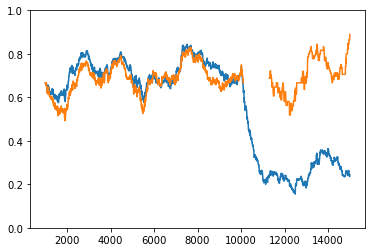

In [ ]:
import matplotlib.pyplot as plt
plt.plot(baseline.metric_results_pred["f1"])
plt.plot(experiment.metric_results_pred["f1"])
plt.ylim([0, 1])

In [ ]:
X_train_raw, y_train = drift_dataloader.access_base_samples(dataset="train")
X_val_raw, y_val = drift_dataloader.access_base_samples(dataset="val")

standardizer = Standardizer()
X_train = standardizer.fit_transform(X_train_raw)
X_val = standardizer.transform(X_val_raw)

In [ ]:
cnn = NNClassifier()
cnn.fit(X_train, y_train, val_X=X_val, val_y=y_val, lrate=1e-2)

Training NN:   0%|          | 0/20 [00:00<?, ?it/s]

/home/tbiegel/nico_files/cms_2023_code/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/models/nnclassifier.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor(X).to(self.device).float(),


KeyboardInterrupt: 